# Seminario B: Programación en Paralelo Proyecto Final
## Simulación de Datos para modelos de aprendizaje automático

Profesor: Miguel Ángel Pérez León<br>
Ayudante: Iván Coss Calderón<br>
Alumno: Gerardo Martínez Ramos

# I. Presentación

### Motivación y Objetivos

**Motivación**
Una de las etapas más importantes durante el desarrollo de modelos de aprendizaje automático o
machine learning es la obtención de datos. Es común que
cuando se utiliza un modelo para resolver algún problema, los datos que se tienen son insuficientes para entrenar
o validar el modelo e incluso muchas veces los datos no
representan todos los escenarios o categorı́as que se están
estudiando. Por esto es necesario generar datos por medio
de simulaciones para explorar diversos casos y validar los
modelos implementados.

**Objetivo**
Dado un conjunto de datos, implementar un método para simulación de datos que realice lo siguiente:
1. Ajustar una distribución a los datos de entrada y devolver el nombre de la distribución con el mejor ajuste, parámetros de ajuste y error del ajuste.
2. Generar un nuevo conjunto de N datos con la distribución encontrada en el paso 1.
3. Validar los datos utilizándolos con modelos de *machine learning*.
4. Evaluar y comparar el desempeño de los modelos.

### 1. Ciclo de Trabajo en Ciencia de Datos

[The Team Data Science Process lifecycle](https://docs.microsoft.com/en-us/azure/machine-learning/team-data-science-process/lifecycle)

[CRISP-DM](https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining)

[DM](https://en.wikipedia.org/wiki/Data_mining#Process)

<img src="img/ciclo_de_datos.png">

Durante la etapa de adquisición de datos, puede llegar a ocurrir que los datos son insuficientes para entrenar o validar un modelo. Incluso muchas veces los datos no representan todos los escenarios o categorı́as que se están estudiando. Algunos de los problemas que esto causa:
- Clases desbalanceadas
- Series de tiempo incompletas
- Sobreajuste o subajuste de modelo

Algo que puede ayudar a mitigar estos problemas es generar datos por medio de simulaciones. De esa manera podemos explorar diversos casos y validar los modelos implementados.

### 2. Tipos de Datos

[Data Types for Machine Learning](https://towardsdatascience.com/7-data-types-a-better-way-to-think-about-data-types-for-machine-learning-939fae99a689)

<img src="img/tipos_de_datos.png">

### 3. Distribuciones de Probabilidad

**Definición**
Una distribución de probabilidad es una función que describe qué tan probable es obtener alguno de los valores que una variable aleatoria puede tomar. Esta puede ser discreta cuando solo se pude tomar un número finito de valores o continua cuando la variable se encuentra en un intervalo continuo. 

**Propiedades Básicas**
- $0 \leq P(x) \leq 1$
- $\sum_{i=1}^{n}P(x_i) = 1$

Ejemplos de algunas Distribuciones:

#### 3.1 Uniforme

<img src="img/uniforme.png">

- Cada evento tiene la misma probabilidad de ocurrir

#### 3.2 Bernoulli

<img src="img/bernoulli.png">

- Solo hay dos posibles resultados para un evento.
- $Éxito = p$, $Fracaso = 1 - p$ 

#### 3.3 Binomial

<img src="img/binomial.png">

- Eventos con resultados binarios.
- Se puede considerar como la suma de los resultados de eventos que siguen una distribución Bernoulli.
- Toma dos parámetros: # de veces que ocurre un evento y la probabilidad asignada al éxito y fracaso.
- Eventos independientes entre sí.

#### 3.4 Gaussiana

<img src="img/normal.png">

- Promedio = Mediana = Moda
- Los valores se distribuyen de forma simétrica respecto al promedio.
- Alrededor del 68% de datos se encuentran a una unidad de desviación estándar del promedio.
- Parámetros: promedio y desviación estándar.
- Modela con precisión varios fenómenos.
- Varios modelos de aprendizaje automático tienen mejor desempeño con datos que sigue esta distribución <br> (Clasificadores de Bayes, Análisis Discriminante Linear o Cuadrático, Modelos de Regresión)

#### 3.5 Poisson

<img src="img/poisson.png">


- Utilizada generalmente para encontrar la probabilidad de que un evento ocurra en un intervalo de tiempo determinado.
- $P(X) = \frac{\lambda^{x}e^{-\lambda}}{X!}$, donde $\lambda$ representa el número de eventos esperados dentro del intervalo de tiempo.
- La ocurrencia de eventos es independiente entre sí.
- No hay límite de ocurrencias para eventos dentro del periodo de tiempo.
- La frecuencia de  ocurrencia entre eventos es constante.

#### 3.6 Exponencial

<img src="img/exponencial.png">

- Utilizada para modelar la diferencia de tiempo entre ocurrencia de deiferentes eventos.
- La función de distribución es decreciente en función de un parámetro $\lambda$, la curva desciende más rápido conforme su valor incrementa.

### 4. SSE

Para encontrar la distribución que mejor se ajusta a un conjunto de datos, necesitamos una métrica para comparar cada distribución que probemos. Para esto utilicé la suma cuadrática de errores:

$$SSE = \sum_{i=0}^{n}(x_i - x_i')^2$$

Donde $x_i$ corresponde al dato real y $x_i'$ corresponde al dato estimado.

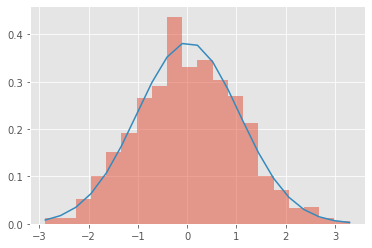

In [40]:
#Ejemplo SSE
data = np.random.normal(0, 1, 1000)
_, bins, _ = plt.hist(data, 20, density=1, alpha=0.5)
mu, sigma = st.norm.fit(data)
best_fit_line = st.norm.pdf(bins, mu, sigma)
plt.plot(bins, best_fit_line)

# II. Código

## 1. Funciones Auxiliares

In [41]:
#importar bibliotecas
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
import scipy.stats as st
import statsmodels as sm
from scipy.stats._continuous_distns import _distn_names # lista de todas las ditribuciones de scipy
import matplotlib
import matplotlib.pyplot as plt
import math
import warnings
import concurrent.futures

In [42]:
# Variables globales

# Configuración para el Notebook
matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')
warnings.filterwarnings('ignore')
%matplotlib inline

# Lista de distribuciones
global DISTRIBUTIONS, x_value, y_value, data_value

#Lista de todas las distribuciones disponibles en scipy
DISTRIBUTIONS =  [st.ksone,st.kstwobign, st.norm, st.alpha, st.anglit, st.arcsine, st.beta,
 st.betaprime, st.bradford, st.burr, st.burr12, st.fisk, st.cauchy, st.chi,
 st.chi2, st.cosine, st.dgamma, st.dweibull, st.expon, st.exponnorm, st.exponweib,
 st.exponpow, st.fatiguelife, st.foldcauchy, st.f, st.foldnorm, st.weibull_min, st.weibull_max,
 st.frechet_r, st.frechet_l, st.genlogistic, st.genpareto, st.genexpon, st.genextreme, st.gamma,
 st.erlang, st.gengamma, st.genhalflogistic, st.gompertz, st.gumbel_r, st.gumbel_l, st.halfcauchy,
 st.halflogistic, st.halfnorm, st.hypsecant, st.gausshyper, st.invgamma, st.invgauss, st.geninvgauss,
 st.norminvgauss, st.invweibull, st.johnsonsb, st.johnsonsu, st.laplace, st.levy, st.levy_l, st.levy_stable,
 st.logistic, st.loggamma, st.loglaplace, st.lognorm, st.gilbrat, st.maxwell, st.mielke, st.kappa4, st.kappa3,
 st.moyal, st.nakagami, st.ncx2, st.ncf, st.t, st.nct, st.pareto, st.lomax, st.pearson3, st.powerlaw,
 st.powerlognorm, st.powernorm, st.rdist, st.rayleigh, st.loguniform, st.reciprocal, st.rice, st.recipinvgauss,
 st.semicircular, st.skewnorm, st.trapz, st.triang, st.truncexpon, st.truncnorm, st.tukeylambda, st.uniform,
 st.vonmises, st.vonmises_line, st.wald, st.wrapcauchy, st.gennorm, st.halfgennorm, st.crystalball, st.argus]

# semilla para números aleatorios
np.random.seed(0) 

In [43]:
# Funciones Auxiliares.
def split_list(x):
    """Función que divide en 5 partes iguales la lista de distribuciones"""
    aux = []
    ini = 0
    tam = 20
    fin = ini + tam
    while fin <= 100:
        aux.append(x[ini:fin])
        ini = fin
        fin = fin + tam
    return aux   
    
def parallelizable_job(distributions):
    """Función que ajusta cada distribución de la lista recibida a los datos"""
    
    global x_value, y_value, data_value
    best_distribution = st.norm  # Inicializamos con una distribución normal
    best_params = (0.0, 1.0)
    best_sse = np.inf            # inicializa el error SSE en infinito positivo.

    # Estima los parámetros de distribución con base en los datos. 
    for distribution in distributions:

        # Intenta ajustar cada distribución
        try:
            # Ignoramos warnings de datos a los que no se les puede ajust|ar una distribución particular-
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # Ajusta la distribución a los datos
                params = distribution.fit(data_value)

                # Separa los parámetros de la distribución
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calcula la función de distribución de probabilidad y calcula el SSE respecto a los datos.
                pdf = distribution.pdf(x_value, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y_value - pdf, 2.0))
                
                # Actualizamos el mejor SSE en caso de ser necesario.
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse
        except Exception as e:
            print(f"Exceptions {e}")
    return (best_distribution.name, best_params, best_sse)

def best_fit_distribution(data, bins, parallel=False):
    """Función que devuelve la distribución de probabilidad
    que mejor se ajusta a un conjunto de datos."""
    try:
        y, x = np.histogram(data, bins=bins, density=True)
        x = (x + np.roll(x, -1))[:-1] / 2.0 # Determina el punto medio de cada intervalo. 
        
        # Definimos las variables globales (para que todos los procesos puedan acceder a estas)
        global x_value, y_value, data_value, results, DISTRIBUTIONS
        x_value = x
        y_value = y
        data_value = data
        results = []
        distributions = DISTRIBUTIONS

        if parallel:        
            split_dist = split_list(distributions)
            with concurrent.futures.ProcessPoolExecutor() as executor: # ThreadPoolExecutor, GIL 
                for dist_list, result in zip(split_dist, executor.map(parallelizable_job, split_dist)):
                    results.append(result) # es seguro con threads/ procesos
            return min(results, key = lambda t: t[2]) # (nombre, (parametros,), sse )
        else:
            return parallelizable_job(distributions)
    except Exception as e:
        pass#print(f"Exception {e}")#print(f"{traceback.format_exc()}")
        
def make_pdf(dist, params, size=10000):
    """Genera la función de densidad de probabilidad de una distribución recibida como parámetro."""
    
    # Separamos los parámetros
    arg = params[:-2]  # todo excepto las últimas dos posiciones (varianza, grados de libertad, etc.)
    loc = params[-2]   # penúltimo parámetro
    scale = params[-1] # último parámetro

    # Determinar puntos de inicio y fin para la distribución recibida como parámetro.
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Calcula la función de densidad de prob. y la convierte a un objeto pd.Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

def best_pdf(data, bins, parallel=False):
    """Función que devuelve la distribución que mejor se ajusta a los datos recibidos como 
    parámetro.
    
    Argumentos:
    data     -- datos a los que se les ajustará una distribución (pd.Series)
    bins     -- número de contenedores en los que se repartirán los datos. (min 10, max 25)
    parallel -- especfica si la ejecución será en paralelo
    """
    num_bins = bins
    
    if parallel:
        best_fit_name, best_fit_params, sse = best_fit_distribution(data, num_bins, parallel=True)
        best_dist = getattr(st, best_fit_name)
    else:
        best_fit_name, best_fit_params, sse = best_fit_distribution(data, num_bins, parallel=False)
        best_dist = getattr(st, best_fit_name)

    # Construye la función de densidad de probabilidad.
    pdf = make_pdf(best_dist, best_fit_params, size=len(data))

    # Grafica la segunda figura para mostrar el mejor ajuste.
    plt.figure(figsize=(12,8))
    ax = pdf.plot(lw=2, label='PDF', legend=True)
    data.plot(kind='hist', bins=num_bins, density=True, alpha=0.5, label='Datos', legend=True, ax=ax)

    param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
    param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
    dist_str = '{}({})'.format(best_fit_name, param_str)

    ax.set_title(u'Distribución que mejor se ajusta a los datos\n' + dist_str + u'  SSE:={0:.7g}'.format(sse))
    ax.set_xlabel('Datos')
    ax.set_ylabel('Frecuencia')

## 2. Ajuste de distribución

Trabajaremos con la base de datos: [Pima Indians Diabetes Dataset](https://www.kaggle.com/uciml/pima-indians-diabetes-database).<br>Primero inspeccionamos los datos para elegir qué atributo simular.

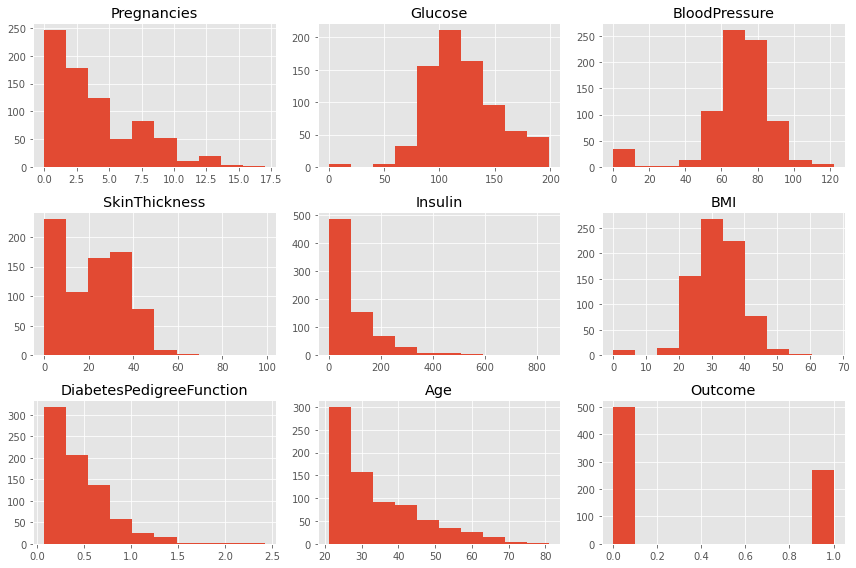

In [4]:
# Cargamos los datos
diabetes_data = pd.read_csv('./diabetes/diabetes.csv')

def draw_histograms(df, variables, n_rows, n_cols):
    """Función que dibuja en un panel el histograma
    de cada columna del DataFrame recibido como parámetro."""
    fig=plt.figure(figsize=(12,8))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name)
    fig.tight_layout() 
    plt.show()

draw_histograms(diabetes_data, diabetes_data.columns, 3, 3)

Elegí el atributo *Glucose*, ahora determinamos el tamaño de los datos a simular y ajustamos una distribución.

In [5]:
len(diabetes_data.Glucose)

768

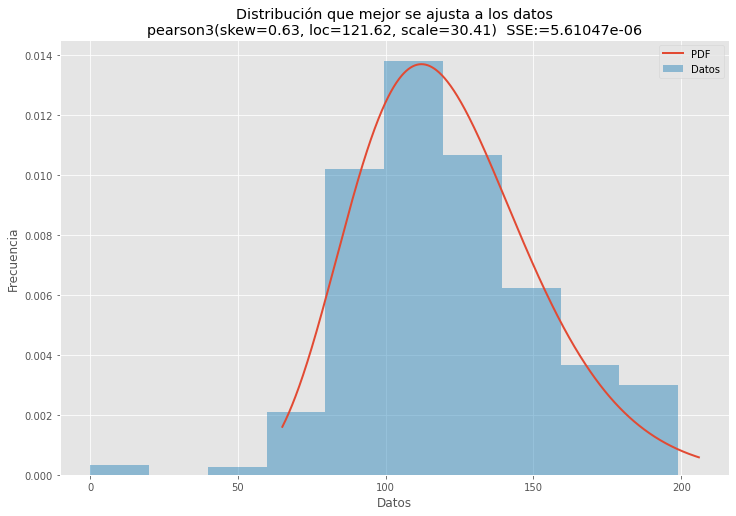

In [6]:
best_pdf(diabetes_data.Glucose, 10, parallel=True)

## 3. Simulación de Datos

(array([ 16.,  93., 166., 164., 160.,  96.,  36.,  22.,  11.,   4.]),
 array([ 56.7324404 ,  73.50836551,  90.28429061, 107.06021571,
        123.83614082, 140.61206592, 157.38799103, 174.16391613,
        190.93984124, 207.71576634, 224.49169144]),
 <a list of 10 Patch objects>)

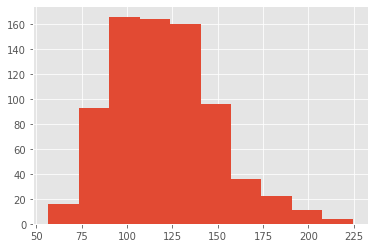

In [7]:
# Generamos los datos y observamos el resultado
simulated_glucose = st.pearson3.rvs(skew=0.63, loc=121.62, scale=30.41, size=768)
plt.hist(simulated_glucose, bins=10)

In [8]:
#Comparamos con el conjunto original
diabetes_data.Glucose.hist()

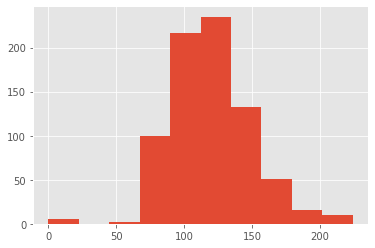

In [9]:
# Realizamos algunos ajustes para acercarnos más a los datos originales y observamos el resultado.

# Hacemos una copia de los datos originales.
diabetes_data_simulated = diabetes_data.sort_values(by=['Glucose']).copy()

# ordenamos los datos simulados
simulated_glucose.sort()

for i in range(5): # ajustamos los primeros 5 valores como 0 para apegarnos lo más posible a los datos originales.
    simulated_glucose[i] = 0

#Reemplazamos la columna glucose con los datos que hemos simulado    
diabetes_data_simulated.Glucose = simulated_glucose 
diabetes_data_simulated.Glucose = diabetes_data_simulated.Glucose.astype('int64') # ajustamos el tipo de datos.

diabetes_data_simulated.Glucose.hist()

## 4. Generación y Evaluación de Modelos

### a) Modelo con datos originales

In [10]:
# Modelado
X =  diabetes_data.drop(["Outcome"],axis = 1)
y = diabetes_data["Outcome"]

#Entrenamiento y pruebas
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 56)

# validación cruzada https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation
cv = StratifiedKFold(n_splits=10, shuffle = False, random_state = 76)

# Regresión Logística https://machinelearningmastery.com/logistic-regression-for-machine-learning/
clf_logreg = LogisticRegression()
# Ajustamos los datos al modelo
clf_logreg.fit(X_train, y_train)
# Realiza predicciones para el conjunto de validación.
y_pred_class_logreg = cross_val_predict(clf_logreg, X_train, y_train, cv = cv)
# Probabilidades predichas para la clase positiva
y_pred_prob_logreg = cross_val_predict(clf_logreg, X_train, y_train, cv = cv, method="predict_proba")
y_pred_prob_logreg_class1 = y_pred_prob_logreg[:, 1]

In [11]:
# Evaluación con datos originales
cross_val_score(clf_logreg, X_train, y_train, cv = cv, scoring = 'roc_auc').mean()

0.8311899681636523

### b) Modelo con datos simulados

In [12]:
X =  diabetes_data_simulated.drop(["Outcome"],axis = 1)
y = diabetes_data_simulated["Outcome"]

#Entrenamiento y pruebas
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 56)

# validación cruzada https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation
cv = StratifiedKFold(n_splits=10, shuffle = False, random_state = 76)

# Regresión Logística https://machinelearningmastery.com/logistic-regression-for-machine-learning/
clf_logreg = LogisticRegression()
# Ajustamos los datos al modelo
clf_logreg.fit(X_train, y_train)
# Realiza predicciones para el conjunto de validación.
y_pred_class_logreg = cross_val_predict(clf_logreg, X_train, y_train, cv = cv)
# Probabilidades predichas para la clase positiva
y_pred_prob_logreg = cross_val_predict(clf_logreg, X_train, y_train, cv = cv, method="predict_proba")
y_pred_prob_logreg_class1 = y_pred_prob_logreg[:, 1]

In [13]:
# Evaluación con datos simulados
cross_val_score(clf_logreg, X_train, y_train, cv = cv, scoring = 'roc_auc').mean()

0.8123709611867508

## 5. Resultados y Conclusiones

### Sobre el método para ajuste de la mejor distribución

#### Pruebas de ejecución

**Especificaciones Técnicas** (Ambiente de Ejecución)

<img src="img/specs.png">


**Calibración**

Para decidir si utilizar procesos o hilos realicé algunas pruebas de ejecución variando el número de hilos/procesos utilizados.

| Tiempo |       Ejecución       |
|:------:|:---------------------:|
| 5’00”  | Secuencial            |
| 4’38”  | Paralela, 10 hilos    |
| 4’32”  | Paralela, 5 hilos     |
| 4’34”  | Paralela, 10 procesos |
| 4’21”  | Paralela, 5 procesos  |

**Secuencial vs Paralelo**

| Tiempo | Distribución | Ejecución  |
|:------:|:------------:|------------|
| 8’27”  | Gaussiana    | Secuencial |
| 7’25”  | Gaussiana    | Paralela   |
| 25’7”  | Exponencial  | Secuencial |
| 24’17” | Exponencial  | Paralela   |
| 35’12” | Chisquare    | Secuencial |
| 34’9”  | Chisquare    | Paralela   |

<img src="img/ajuste_normal.png">
<img src="img/ajuste_exponencial.png">
<img src="img/ajuste_chisquare.png">

- Se obtuvo una mejora en tiempo de ejecución de 13 %  (Secuencial vs Paralelo)
- El tiempo de ejecución varía mucho de acuerdo a los datos recibidos.<br> Esto se debe a que la función descarta algunas distribuciones de la lista que son imposibles de ajustar a los datos recibidos.


### Optimizaciones

- Filtrar la función de ajuste a un subconjunto de la lista de distribución.
- Simular variables objetivo (esto debe considerar correlación de variables, datos nulos, etc.)
- Justificar el uso de métricas en el proyecto (ROC_AUC, SSE  )
- Utilizar más funciones para medir el error además de SSE (qqplot, Kolmogorov-Smirnov)